In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split


df = pd.read_csv("..//static//csv//DiamondsPrices2022.csv", index_col="Unnamed: 0")

print(df.columns, "\n")

print(df.info, "\n")

Index(['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'price', 'x', 'y',
       'z'],
      dtype='object') 

<bound method DataFrame.info of        carat        cut color clarity  depth  table  price     x     y     z
1       0.23      Ideal     E     SI2   61.5   55.0    326  3.95  3.98  2.43
2       0.21    Premium     E     SI1   59.8   61.0    326  3.89  3.84  2.31
3       0.23       Good     E     VS1   56.9   65.0    327  4.05  4.07  2.31
4       0.29    Premium     I     VS2   62.4   58.0    334  4.20  4.23  2.63
5       0.31       Good     J     SI2   63.3   58.0    335  4.34  4.35  2.75
...      ...        ...   ...     ...    ...    ...    ...   ...   ...   ...
53939   0.86    Premium     H     SI2   61.0   58.0   2757  6.15  6.12  3.74
53940   0.75      Ideal     D     SI2   62.2   55.0   2757  5.83  5.87  3.64
53941   0.71    Premium     E     SI1   60.5   55.0   2756  5.79  5.74  3.49
53942   0.71    Premium     F     SI1   59.8   62.0   2756  5.74  5.73  3.43
5394

Бизнес цели
1. Оптимизация ценообразования. Анализ между характиристик и цен. Это поможет опеделять цену камня в зависимости от его качеств.
2. Разделение камней для разного сигмента рынка. В зависимости от характиристик камня делать его более доступным или премиальным.

Цели технического проекта

Для первой БЦ
1. Разработка модели предсказания стоимости бриллианта
2. Анализ факторов, влияющих на стоимость

Для второй БЦ
1. Создание системы кластеризации бриллиантов

Нужно выявить какие проблемы есть в данных.
Начнем с поиском зашумленности

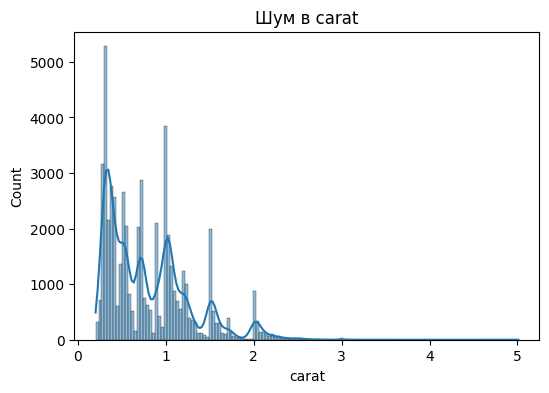

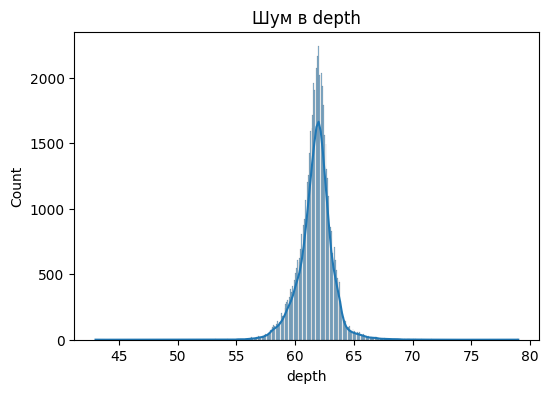

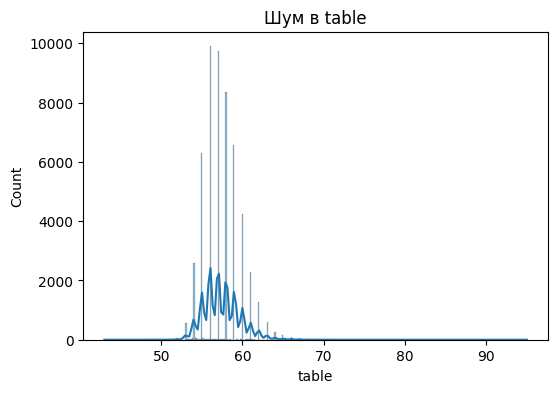

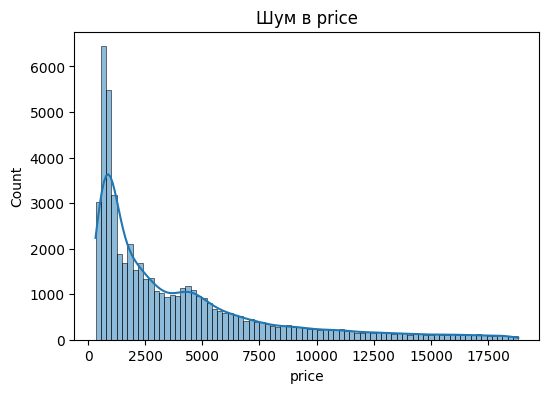

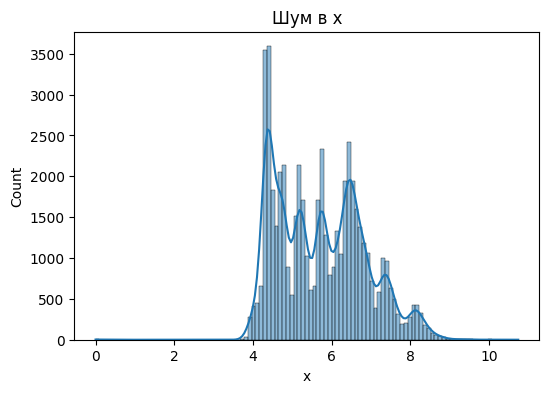

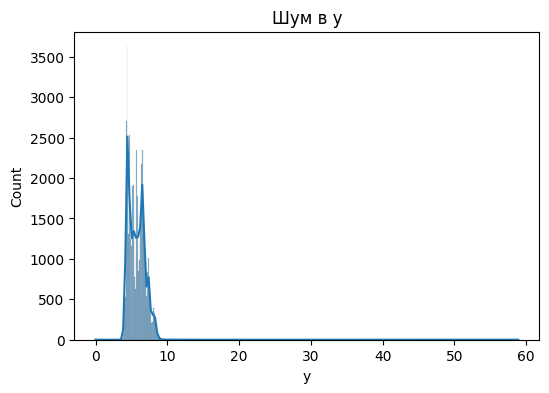

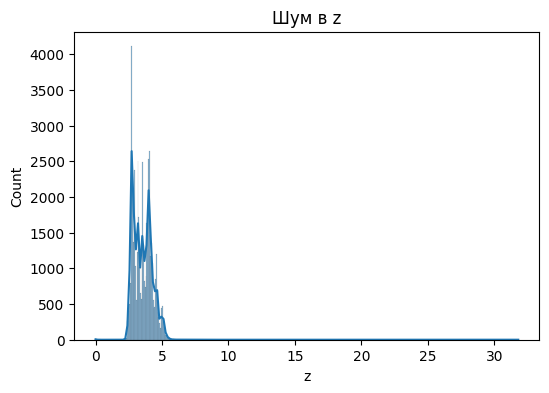

In [2]:
for column in df.select_dtypes(include=['float64', 'int64']).columns:
    plt.figure(figsize=(6, 4))
    sns.histplot(df[column], kde=True)
    plt.title(f'Шум в {column}')
    plt.show

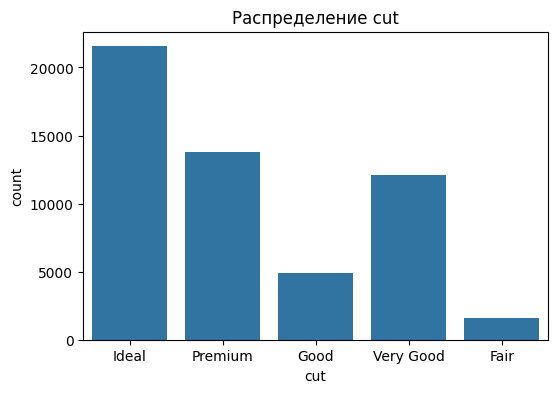

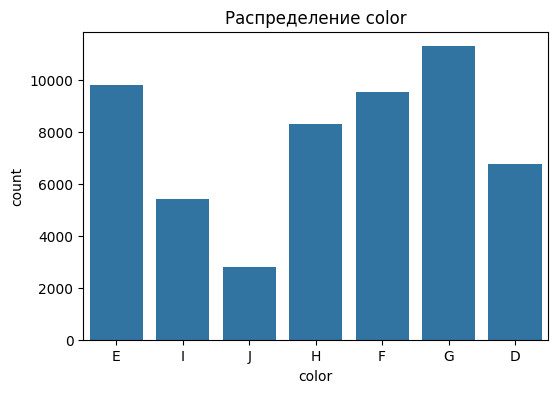

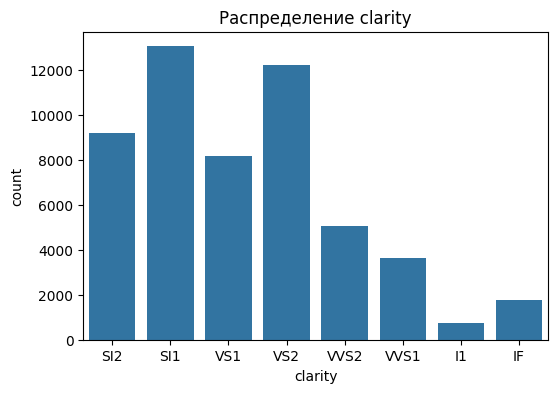

In [3]:
for column in ['cut', 'color', 'clarity']:
    plt.figure(figsize=(6,4))
    sns.countplot(data=df, x=column)
    plt.title(f'Распределение {column}')
    plt.show

Ищем выбросы

In [4]:
from scipy.stats import zscore

outliers = df[(zscore(df.select_dtypes(include=['float64', 'int64'])) > 3).any(axis=1)]
print(f"Количество выбросов (z-score): {len(outliers)}")

df_copy = df.copy()
for column in df.select_dtypes(include=['float64', 'int64']).columns:
    median = df[column].median()
    std_dev = df[column].std()
    df_copy[column] = np.where(zscore(df[column]) > 3, median, df[column])

outliers_after = df_copy[(zscore(df_copy.select_dtypes(include=['float64', 'int64'])) > 3).any(axis=1)]
print(f"Количество выбросов после замены на медиану: {len(outliers_after)}")


Количество выбросов (z-score): 2077
Количество выбросов после замены на медиану: 1532


Скорее всего тут реальные данные, поэтому убрав самые большие остальные оставим.

Ищем корреляции

In [5]:
correlations = df.select_dtypes(include=['float64', 'int64']).corr()['price'].sort_values(ascending=False)
print("Корреляция признаков с целевой переменной 'price':")
print(correlations)

Корреляция признаков с целевой переменной 'price':
price    1.000000
carat    0.921591
x        0.884433
y        0.865419
z        0.861249
table    0.127118
depth   -0.010630
Name: price, dtype: float64


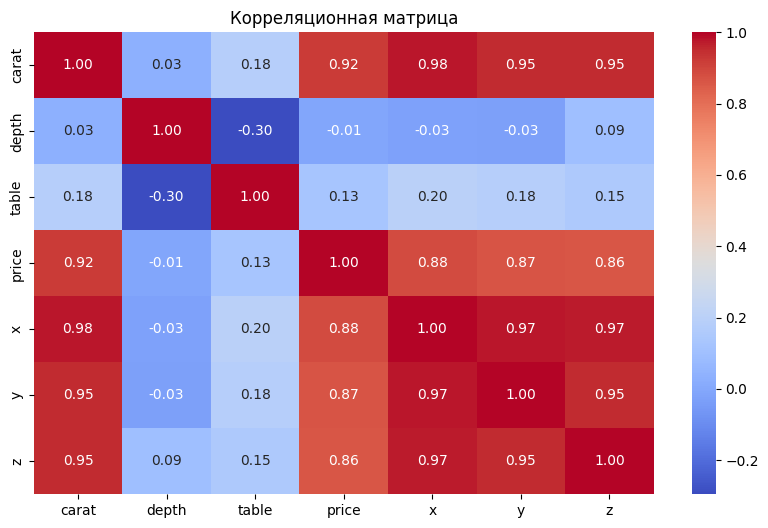

In [6]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.select_dtypes(include=['float64', 'int64']).corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Корреляционная матрица")
plt.show()

Корреляция признаков с целевой переменной 'price' для 'cut', 'color', 'clarity':
price            1.000000
clarity_SI2      0.128427
color_I          0.097130
cut_Premium      0.095685
color_J          0.081714
color_H          0.059229
clarity_SI1      0.008940
color_G          0.008564
cut_Very Good    0.006589
cut_Good        -0.000307
clarity_VS2     -0.001066
clarity_VS1     -0.009879
color_F         -0.024166
clarity_IF      -0.049593
clarity_VVS2    -0.052375
clarity_VVS1    -0.095261
cut_Ideal       -0.097160
color_E         -0.101101
Name: price, dtype: float64


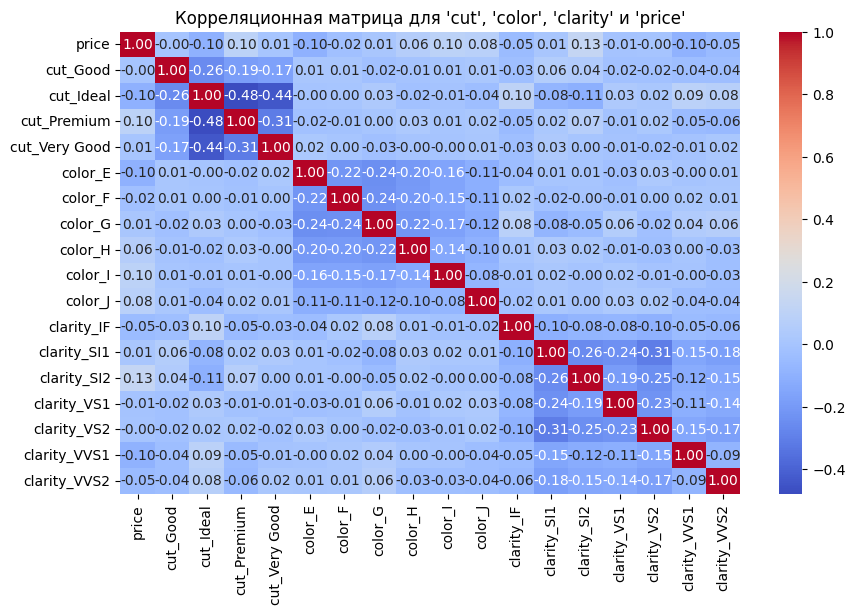

In [7]:
df_dummies = pd.get_dummies(df, columns=['cut', 'color', 'clarity'], drop_first=True)

selected_columns = ['price'] + [col for col in df_dummies.columns if 'cut_' in col or 'color_' in col or 'clarity_' in col]
correlation_matrix = df_dummies[selected_columns].corr()

correlations = df_dummies[selected_columns].corr()['price'].sort_values(ascending=False)
print("Корреляция признаков с целевой переменной 'price' для 'cut', 'color', 'clarity':")
print(correlations)

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Корреляционная матрица для 'cut', 'color', 'clarity' и 'price'")
plt.show()


Вывод такое:<br>
Сильное влияние на цену оказывают характиристики 'carat', 'x', 'y', 'z'.<br>
Низкое влияние оказывают 'table', 'cut', 'color', 'clarity'.<br>
А признак 'depth' не оказывает влияни вовсе.

Выполним разбиение каждого набора данных на обучающую, контрольную и тестовую выборки для устранения проблемы просачивания данных

In [8]:
train_data, temp_data = train_test_split(df, test_size=0.3, random_state=42)
validation_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

train_size = len(train_data)
validation_size = len(validation_data)
test_size = len(test_data)

train_size, validation_size, test_size

(37760, 8091, 8092)

Оцень сбалансированность выборки

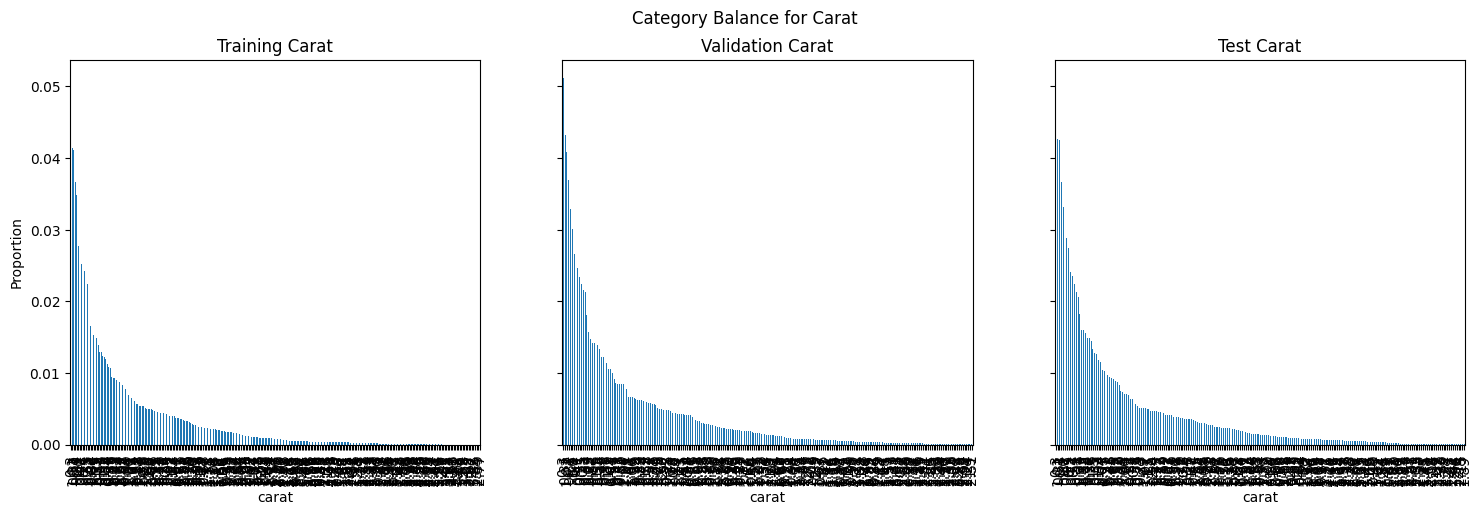

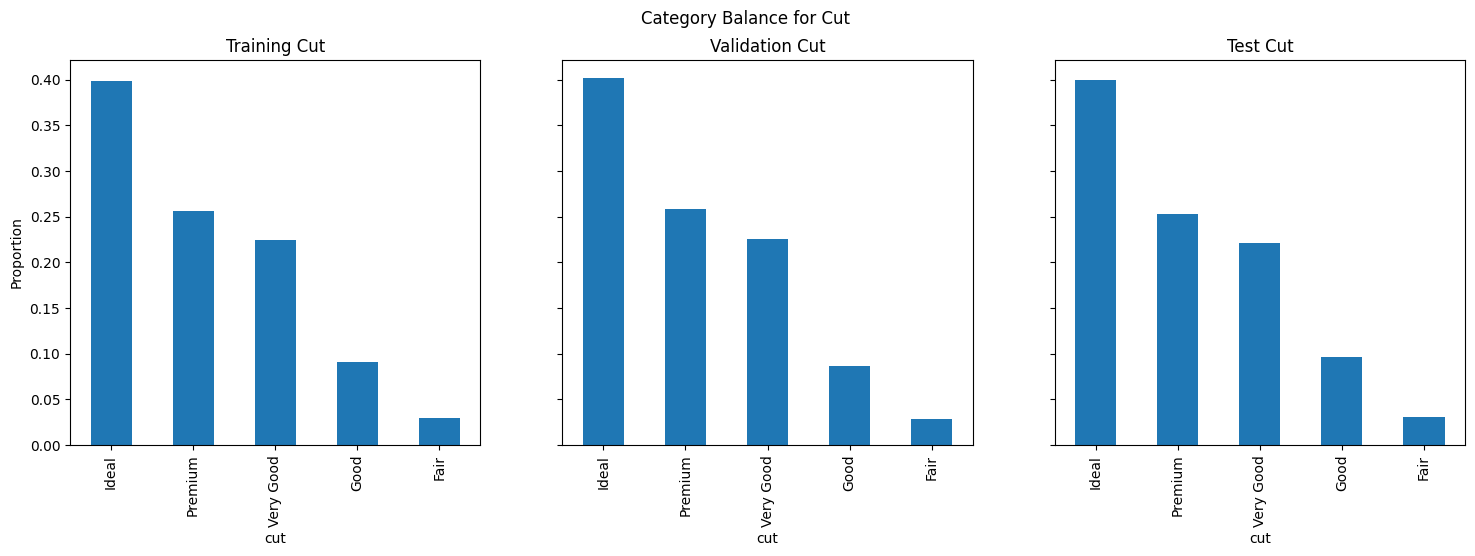

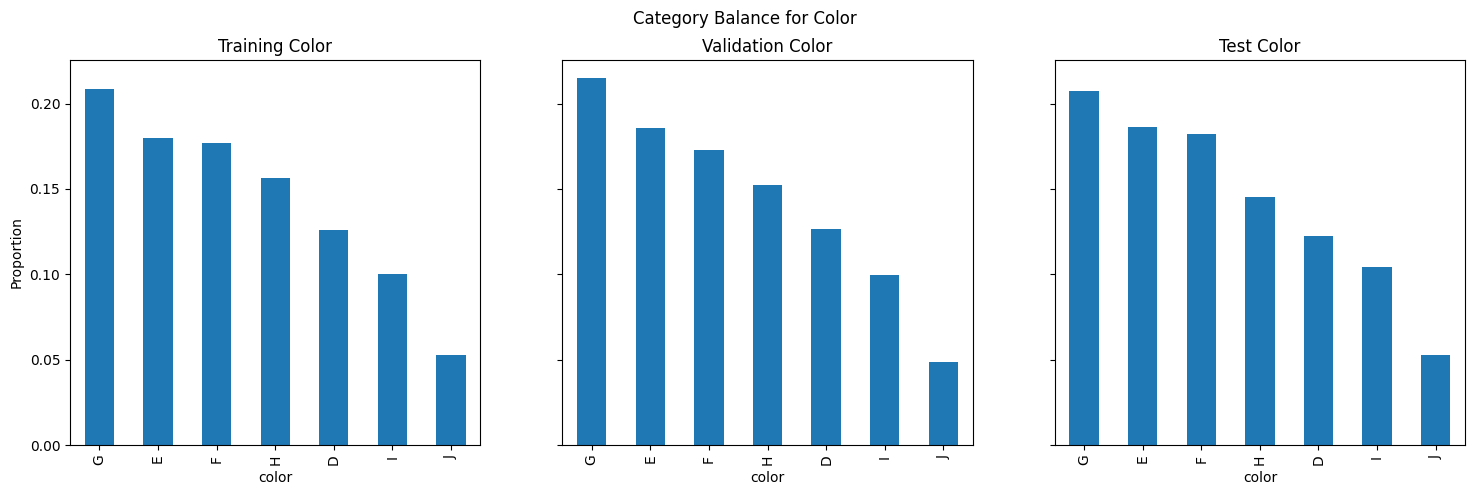

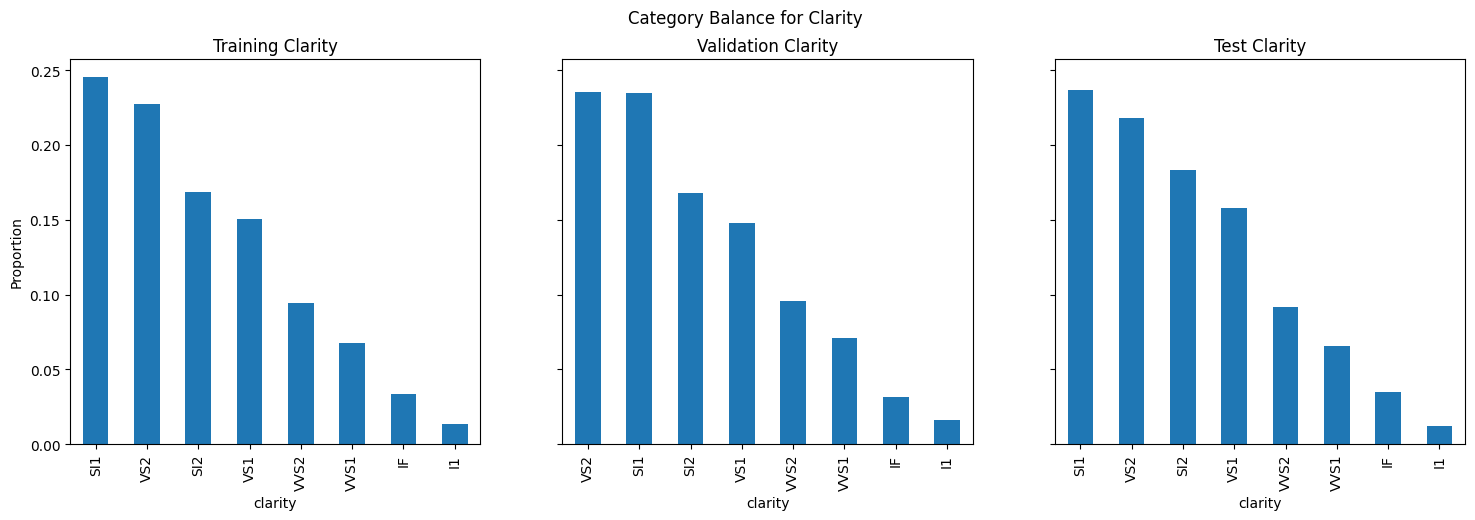

In [9]:
def plot_category_balance(train_data, validation_data, test_data, column, title):
    fig, ax = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
    
    train_data[column].value_counts(normalize=True).plot(kind='bar', ax=ax[0])
    ax[0].set_title(f'Training {title}')
    ax[0].set_ylabel('Proportion')
    
    validation_data[column].value_counts(normalize=True).plot(kind='bar', ax=ax[1])
    ax[1].set_title(f'Validation {title}')
    
    test_data[column].value_counts(normalize=True).plot(kind='bar', ax=ax[2])
    ax[2].set_title(f'Test {title}')
    
    plt.suptitle(f'Category Balance for {title}')
    plt.show()

plot_category_balance(train_data, validation_data, test_data, 'carat', 'Carat')
plot_category_balance(train_data, validation_data, test_data, 'cut', 'Cut')
plot_category_balance(train_data, validation_data, test_data, 'color', 'Color')
plot_category_balance(train_data, validation_data, test_data, 'clarity', 'Clarity')


Буду использовать увеличение выборки (Oversampling) для "Clarity"

In [10]:
from imblearn.over_sampling import RandomOverSampler

print("До Oversampling: ", train_data['clarity'].value_counts())

ros = RandomOverSampler(sampling_strategy='auto', random_state=42)

X_train = train_data.drop(columns=['clarity']) # все данные, кроме столбца clarity, то есть признаки, используемые для предсказания
y_train = train_data['clarity'] # целевой столбец clarity, который содержит классы, которые нужно сбалансировать

X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

train_data_resampled = X_resampled.copy()
train_data_resampled['clarity'] = y_resampled

print("После Oversampling: ", train_data_resampled['clarity'].value_counts())

До Oversampling:  clarity
SI1     9256
VS2     8590
SI2     6355
VS1     5694
VVS2    3551
VVS1    2547
IF      1254
I1       513
Name: count, dtype: int64
После Oversampling:  clarity
VVS1    9256
SI1     9256
SI2     9256
VVS2    9256
VS2     9256
VS1     9256
IF      9256
I1      9256
Name: count, dtype: int64


Используем Undersampling для "Cut"

In [11]:
from imblearn.under_sampling import RandomUnderSampler

print("До Undersampling: ", train_data_resampled['cut'].value_counts())

undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_train_cut = train_data_resampled.drop(columns=['cut'])
y_train_cut = train_data_resampled['cut']
X_resampled_cut, y_resampled_cut = undersampler.fit_resample(X_train_cut, y_train_cut)

train_data_resampled_cut = X_resampled_cut.copy()
train_data_resampled_cut['cut'] = y_resampled_cut

print("После Undersampling: ", train_data_resampled_cut['cut'].value_counts())
print("Столбцы после Undersampling:", train_data_resampled_cut.columns)

До Undersampling:  cut
Ideal        31497
Premium      17342
Very Good    14994
Good          6338
Fair          3877
Name: count, dtype: int64
После Undersampling:  cut
Fair         3877
Good         3877
Ideal        3877
Premium      3877
Very Good    3877
Name: count, dtype: int64
Столбцы после Undersampling: Index(['carat', 'color', 'depth', 'table', 'price', 'x', 'y', 'z', 'clarity',
       'cut'],
      dtype='object')


И увеличиваем количество меньших значений в 'carat' с помощью Oversampling

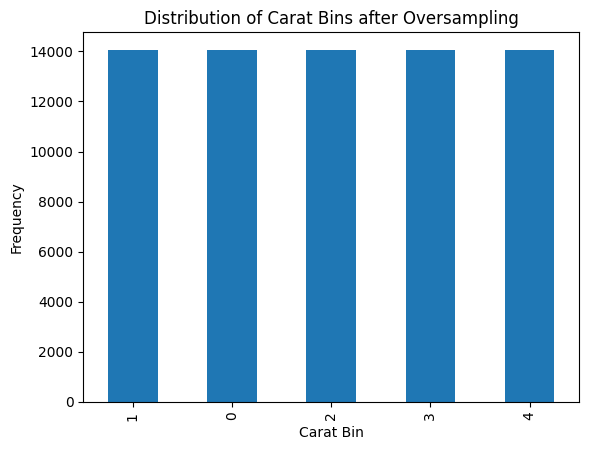

Столбцы после Oversampling: Index(['carat', 'color', 'depth', 'table', 'price', 'x', 'y', 'z', 'clarity',
       'cut', 'carat_binned'],
      dtype='object')


In [12]:
train_data_resampled_cut['carat_binned'] = pd.cut(train_data_resampled_cut['carat'], bins=5, labels=False)

X_train_carat = train_data_resampled_cut.drop(columns=['carat_binned'])
y_train_carat = train_data_resampled_cut['carat_binned']

oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)
X_resampled_carat, y_resampled_carat = oversampler.fit_resample(X_train_carat, y_train_carat)

train_data_resampled_carat = X_resampled_carat.copy()
train_data_resampled_carat['carat_binned'] = y_resampled_carat

train_data_resampled_carat['carat_binned'].value_counts().plot(kind='bar')
plt.title("Distribution of Carat Bins after Oversampling")
plt.xlabel("Carat Bin")
plt.ylabel("Frequency")
plt.show()

print("Столбцы после Oversampling:", train_data_resampled_carat.columns)


Конструирование признаков

In [13]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler

categorical_features = ['cut', 'color', 'clarity']

encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded_data = pd.DataFrame(encoder.fit_transform(train_data_resampled_carat[categorical_features]))
encoded_data.columns = encoder.get_feature_names_out(categorical_features)

train_data_encoded = pd.concat([train_data_resampled_carat.reset_index(drop=True), encoded_data], axis=1)

print(train_data_encoded.head())

   carat color  depth  table  price     x     y     z clarity   cut  ...  \
0   1.50     G   64.5   57.0  10352  7.15  7.09  4.59     SI1  Fair  ...   
1   0.60     G   65.7   55.0   1197  5.31  5.23  3.46     SI1  Fair  ...   
2   1.83     J   70.0   58.0   5083  7.34  7.28  5.12      I1  Fair  ...   
3   0.90     D   63.8   61.0   4252  6.07  5.99  3.85     SI1  Fair  ...   
4   0.71     G   65.7   56.0   2274  5.51  5.54  3.63     VS2  Fair  ...   

   color_H  color_I  color_J  clarity_IF  clarity_SI1  clarity_SI2  \
0      0.0      0.0      0.0         0.0          1.0          0.0   
1      0.0      0.0      0.0         0.0          1.0          0.0   
2      0.0      0.0      1.0         0.0          0.0          0.0   
3      0.0      0.0      0.0         0.0          1.0          0.0   
4      0.0      0.0      0.0         0.0          0.0          0.0   

   clarity_VS1  clarity_VS2  clarity_VVS1  clarity_VVS2  
0          0.0          0.0           0.0           0.0  
1     

In [14]:
num_bins = 5

train_data_encoded['carat_binned'] = pd.cut(train_data_encoded['carat'], bins=num_bins, labels=False)
train_data_encoded['depth_binned'] = pd.cut(train_data_encoded['depth'], bins=num_bins, labels=False)
train_data_encoded['table_binned'] = pd.cut(train_data_encoded['table'], bins=num_bins, labels=False)
train_data_encoded['price_binned'] = pd.cut(train_data_encoded['price'], bins=num_bins, labels=False)

print(train_data_encoded[['carat', 'carat_binned', 'depth', 'depth_binned', 
                         'table', 'table_binned', 'price', 'price_binned']].head())


   carat  carat_binned  depth  depth_binned  table  table_binned  price  \
0   1.50             1   64.5             2   57.0             1  10352   
1   0.60             0   65.7             3   55.0             1   1197   
2   1.83             1   70.0             3   58.0             2   5083   
3   0.90             0   63.8             2   61.0             2   4252   
4   0.71             0   65.7             3   56.0             1   2274   

   price_binned  
0             2  
1             0  
2             1  
3             1  
4             0  


Ручной синтез

In [15]:
data = train_data_encoded.copy()

data['price_per_carat'] = data['price'] / data['carat']
data['volume'] = data['x'] * data['y'] * data['z']
data['surface_area'] = data['table'] * data['depth'] / 100


data['cut_score'] = data['cut'].map({'Fair': 1, 'Good': 2, 'Very Good': 3, 'Premium': 4, 'Ideal': 5})
data['color_score'] = data['color'].map({'J': 1, 'I': 2, 'H': 3, 'G': 4, 'F': 5, 'E': 6, 'D': 7})
data['clarity_score'] = data['clarity'].map({'I1': 1, 'SI2': 2, 'SI1': 3, 'VS2': 4, 'VS1': 5, 'VVS2': 6, 'VVS1': 7, 'IF': 8})
data['quality_score'] = data['cut_score'] + data['color_score'] + data['clarity_score']

Масштабирование признаков

In [16]:
features_to_scale = ['carat', 'price', 'price_per_carat', 'volume', 'surface_area', 'quality_score']

#  Стандартизация признаков
scaler_standard = StandardScaler()
data_standardized = pd.DataFrame(scaler_standard.fit_transform(data[features_to_scale]), columns=[f"{col}_standard" for col in features_to_scale])

# Нормализация признаков
scaler_minmax = MinMaxScaler()
data_normalized = pd.DataFrame(scaler_minmax.fit_transform(data[features_to_scale]), columns=[f"{col}_norm" for col in features_to_scale])

data = pd.concat([data.reset_index(drop=True), data_standardized, data_normalized], axis=1) # теперь их объеденяем

print(data.head())

   carat color  depth  table  price     x     y     z clarity   cut  ...  \
0   1.50     G   64.5   57.0  10352  7.15  7.09  4.59     SI1  Fair  ...   
1   0.60     G   65.7   55.0   1197  5.31  5.23  3.46     SI1  Fair  ...   
2   1.83     J   70.0   58.0   5083  7.34  7.28  5.12      I1  Fair  ...   
3   0.90     D   63.8   61.0   4252  6.07  5.99  3.85     SI1  Fair  ...   
4   0.71     G   65.7   56.0   2274  5.51  5.54  3.63     VS2  Fair  ...   

   price_per_carat_standard  volume_standard  surface_area_standard  \
0                  1.486375        -0.636594               0.011271   
1                 -1.179201        -1.340819              -0.335758   
2                 -0.754022        -0.425704               2.123745   
3                  0.303687        -1.114517               1.197231   
4                 -0.523003        -1.264937               0.026144   

   quality_score_standard  carat_norm  price_norm  price_per_carat_norm  \
0                0.046561    0.302326    

In [17]:
import featuretools as ft

data = train_data_encoded.copy()  # Используем предобработанные данные

es = ft.EntitySet(id="diamonds")

es = es.add_dataframe(dataframe_name="diamonds_data", dataframe=data, index="index")

feature_matrix, feature_defs = ft.dfs(
    entityset=es, 
    target_dataframe_name="diamonds_data",
    max_depth=2
)

print(feature_matrix.head())

c:\Users\salih\OneDrive\Рабочий стол\3 курас\МИИ\laba1\AIM-PIbd-31-Yaruskin-S-A\aimenv\Lib\site-packages\featuretools\entityset\entityset.py:1733: UserWarning: index index not found in dataframe, creating new integer column
  warnings.warn(
c:\Users\salih\OneDrive\Рабочий стол\3 курас\МИИ\laba1\AIM-PIbd-31-Yaruskin-S-A\aimenv\Lib\site-packages\woodwork\type_sys\utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
c:\Users\salih\OneDrive\Рабочий стол\3 курас\МИИ\laba1\AIM-PIbd-31-Yaruskin-S-A\aimenv\Lib\site-packages\woodwork\type_sys\utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
c:\Users\salih\OneDrive\Рабочий стол\3 курас\МИИ\laba1\AIM-PIbd-31-Yaruskin-S-A\aim

       carat color  depth  table  price     x     y     z clarity   cut  ...  \
index                                                                    ...   
0       1.50     G   64.5   57.0  10352  7.15  7.09  4.59     SI1  Fair  ...   
1       0.60     G   65.7   55.0   1197  5.31  5.23  3.46     SI1  Fair  ...   
2       1.83     J   70.0   58.0   5083  7.34  7.28  5.12      I1  Fair  ...   
3       0.90     D   63.8   61.0   4252  6.07  5.99  3.85     SI1  Fair  ...   
4       0.71     G   65.7   56.0   2274  5.51  5.54  3.63     VS2  Fair  ...   

       clarity_IF  clarity_SI1  clarity_SI2  clarity_VS1  clarity_VS2  \
index                                                                   
0             0.0          1.0          0.0          0.0          0.0   
1             0.0          1.0          0.0          0.0          0.0   
2             0.0          0.0          0.0          0.0          0.0   
3             0.0          1.0          0.0          0.0          0.0   
4

Оцениваем качество каждого набора<br>
В коде есть комментарии указывающие что мы сейчас оцениваем.

In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score
import time

categorical_features = ['cut', 'color', 'clarity']
encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded_data = pd.DataFrame(encoder.fit_transform(data[categorical_features]))
encoded_data.columns = encoder.get_feature_names_out(categorical_features)

data_encoded = pd.concat([data.drop(columns=categorical_features), encoded_data], axis=1)

X = data_encoded.drop(columns=['price'])  # Признаки
y = data_encoded['price']  # Целевая переменная


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# 1. Оценка предсказательной способности
model = LinearRegression()

cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
mean_mse = -np.mean(cv_scores)
print("Предсказательная способность (MSE):", mean_mse)


# 2. Оценка скорости вычисления
start_time = time.time()
model.fit(X_train, y_train)
train_time = time.time() - start_time

start_time = time.time()
y_pred = model.predict(X_test)
predict_time = time.time() - start_time

print("Скорость обучения:", train_time, "секунд")
print("Скорость предсказания:", predict_time, "секунд")

# 3. Оценка надежности
std_mse = np.std(-cv_scores)
print("Надежность (стабильность MSE):", std_mse)

# 4. Оценка корреляции
correlation_matrix = X.corr()
print("Корреляционная матрица признаков:\n", correlation_matrix)

# 5. Оценка цельности
print("Пропуски в данных:\n", data.isnull().sum())
print("Сводка по данным:\n", data.describe())


Предсказательная способность (MSE): 769447.425412744
Скорость обучения: 0.9312052726745605 секунд
Скорость предсказания: 0.009320497512817383 секунд
Надежность (стабильность MSE): 9415.05041335384
Корреляционная матрица признаков:
                   index     carat     depth     table         x         y  \
index          1.000000  0.918976  0.256560 -0.012994  0.881745  0.881997   
carat          0.918976  1.000000  0.317029  0.011338  0.965007  0.964633   
depth          0.256560  0.317029  1.000000 -0.523388  0.214227  0.212123   
table         -0.012994  0.011338 -0.523388  1.000000  0.068165  0.061429   
x              0.881745  0.965007  0.214227  0.068165  1.000000  0.998661   
y              0.881997  0.964633  0.212123  0.061429  0.998661  1.000000   
z              0.874093  0.962961  0.422732 -0.067003  0.966991  0.966578   
carat_binned   0.936744  0.980069  0.299586 -0.006563  0.954800  0.954348   
cut_Good      -0.197076 -0.178975 -0.244465  0.324476 -0.140993 -0.137115  

По итогу MSE у меня равен 769447.43, что можно считать относительно высоким. В последующих работах я буду лучше больше уделять времени на выборки данных, для повышения точности предсказаний.